In [1]:
from core.sequence_utils import OneHotSeqEncoder
from core.unet_model import RNAFlowMatchingModel
from core.dirichlet_likelihood import NegativeLogDirichletLikelihood

from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import torch
from torch import nn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


device = 'cuda:0'

/home/iris/Desktop/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('little_train.txt', sep='\t', names=['sequence', 'expression'])
df = df[(df['sequence'].apply(len) == 110) & (df['expression'] > 12)]

LEFT_ADAPTER = "TGCATTTTTTTCACATC" 
RIGHT_ADAPTER = "GGTTACGGCTGTT"

no_adapter_slice = slice(len(LEFT_ADAPTER), -len(RIGHT_ADAPTER))

df['sequence'] = df['sequence'].apply(lambda x: x[no_adapter_slice])
df

,sequence,expression
3,TTTCGTCACCATTAGTTTGCGCGTAGTTCCGTGGCACGTGTGCTCT...,12.34555
10,GTGATTGCGGTTTTACGTGTTTTGGTGGATATATAGGGGTTTAAAC...,13.77490
17,GTATGTGGGGGTGTCCAGTCTGTGGGAAATGGAGTACGGTTGCGGG...,14.00000
20,CAGCGGGCGGCCGCGCTCCAGGGATATTTTGTATGCGTCAGGTTGC...,13.00000
21,TCCTTGTACGTGTCTCACTAGTTCTTCGGTCAGCGTGCGGTTGCGA...,15.15530
...,...,...
99973,AGTGATAAACAGACAGAGGACCCGGGTTCGGTGGCCCGTCTTTTTA...,15.00000
99976,GGCGGGGTCACGTTCTCTAAATGTCGGCTAAGCCATAAGCTACAGG...,16.00000
99984,GATGAGAACGAAGCGTTCGTTCAATGTTATAACTCCGTGTTTGGAA...,13.00000
99993,GTGCAGGATAGGTGCTATGCATGGAAGCGGCAAATGTGTTGCCGTG...,14.00000


In [3]:
ohse = OneHotSeqEncoder()
dataset = [ohse(seq) for seq in df['sequence']]

loader = DataLoader(dataset, batch_size=1024, shuffle=True)

In [4]:
def train_loop(model, loader, criterion, optimizer, scheduler, history: list[float], device):
    for batch in tqdm(loader):
        time = torch.randint(0, model.num_time_steps - 1, size=(batch.shape[0], 1, 1)).to(device)
        batch = batch.to(device)
        sequences_at_time_t = model.draw_points_at_time_t(batch, time)
        # print(sequences_at_time_t)
        # break
        alphas = model.predict_dirichlet_params(sequences_at_time_t, time)
        loss = criterion(alphas, batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        history.append(loss.item())
        
    scheduler.step()

In [7]:
model = RNAFlowMatchingModel(
    unet_hidden_dim=128,
    num_time_steps=1000,
    time_denominator=1,
    device='cuda:0'
)

optimizer = torch.optim.Adam(model.unet.parameters(), lr=1e-3, weight_decay=1e-6)
criterion = NegativeLogDirichletLikelihood()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
history_loss = []

In [19]:
for epoch in tqdm(range(10)):
    res = train_loop(model, loader, criterion, optimizer, scheduler, history_loss, device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

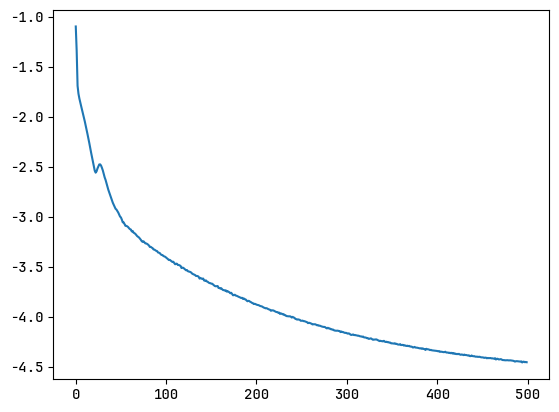

In [20]:
plt.plot(history_loss)

In [21]:
preds = model.generate(num_samples=1)
preds

tensor([[[0.3867, 0.4182, 0.0988, 0.1066, 0.1268, 0.1103, 0.3869, 0.3908,
          0.1488, 0.1429, 0.3533, 0.3462, 0.1019, 0.1141, 0.4199, 0.4153,
          0.3663, 0.3498, 0.1460, 0.1527, 0.1502, 0.1515, 0.3300, 0.3890,
          0.1239, 0.1256, 0.3511, 0.3835, 0.1478, 0.1401, 0.4025, 0.3989,
          0.1115, 0.1139, 0.3702, 0.3802, 0.1013, 0.1171, 0.4397, 0.4047,
          0.4014, 0.4169, 0.1275, 0.1181, 0.1906, 0.1820, 0.2661, 0.2991,
          0.2016, 0.2068, 0.2852, 0.2927, 0.3771, 0.3641, 0.1306, 0.1287,
          0.1277, 0.1176, 0.3536, 0.3727, 0.1362, 0.1495, 0.3555, 0.3618,
          0.1365, 0.1407, 0.3627, 0.3605, 0.1273, 0.1105, 0.3754, 0.3936,
          0.3051, 0.2867, 0.1746, 0.1765, 0.1039, 0.1360, 0.3743, 0.3705],
         [0.1991, 0.2280, 0.2671, 0.2549, 0.1696, 0.1840, 0.3129, 0.3318,
          0.1280, 0.1281, 0.3711, 0.3707, 0.2630, 0.2509, 0.2252, 0.2285,
          0.1125, 0.1130, 0.3989, 0.4049, 0.3761, 0.3748, 0.1221, 0.1279,
          0.1328, 0.1239, 0.3669, 0.3

In [24]:
import matplotlib

matplotlib.font_manager.fontManager.addfont('/usr/share/fonts/truetype/JetBrainsMono/JetBrainsMono-Medium.ttf')

matplotlib.pyplot.rcParams['font.family'] = 'JetBrains Mono'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


# Convert hex to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i + 2], 16) for i in (0, 2, 4))


# Interpolate between two RGB colors
def interpolate_color(color1, color2, t):
    return tuple(int(a + (b - a) * t) for a, b in zip(color1, color2))


# Generate a gradient from hex1 to hex2
def generate_gradient(hex1, hex2, steps=256):
    rgb1 = hex_to_rgb(hex1)
    rgb2 = hex_to_rgb(hex2)
    return [interpolate_color(rgb1, rgb2, t / (steps - 1)) for t in range(steps)]


# Create a custom colormap
def create_colormap(hex_start, hex_end, steps=256):
    gradient_rgb = generate_gradient(hex_start, hex_end, steps)
    gradient_rgb_normalized = [(r / 255, g / 255, b / 255) for r, g, b in gradient_rgb]
    return ListedColormap(gradient_rgb_normalized)


# Example usage
hex_start = '#FFFFFF'  # Red
hex_end = '#237AE0'  # Blue
custom_cmap = create_colormap(hex_start, hex_end)

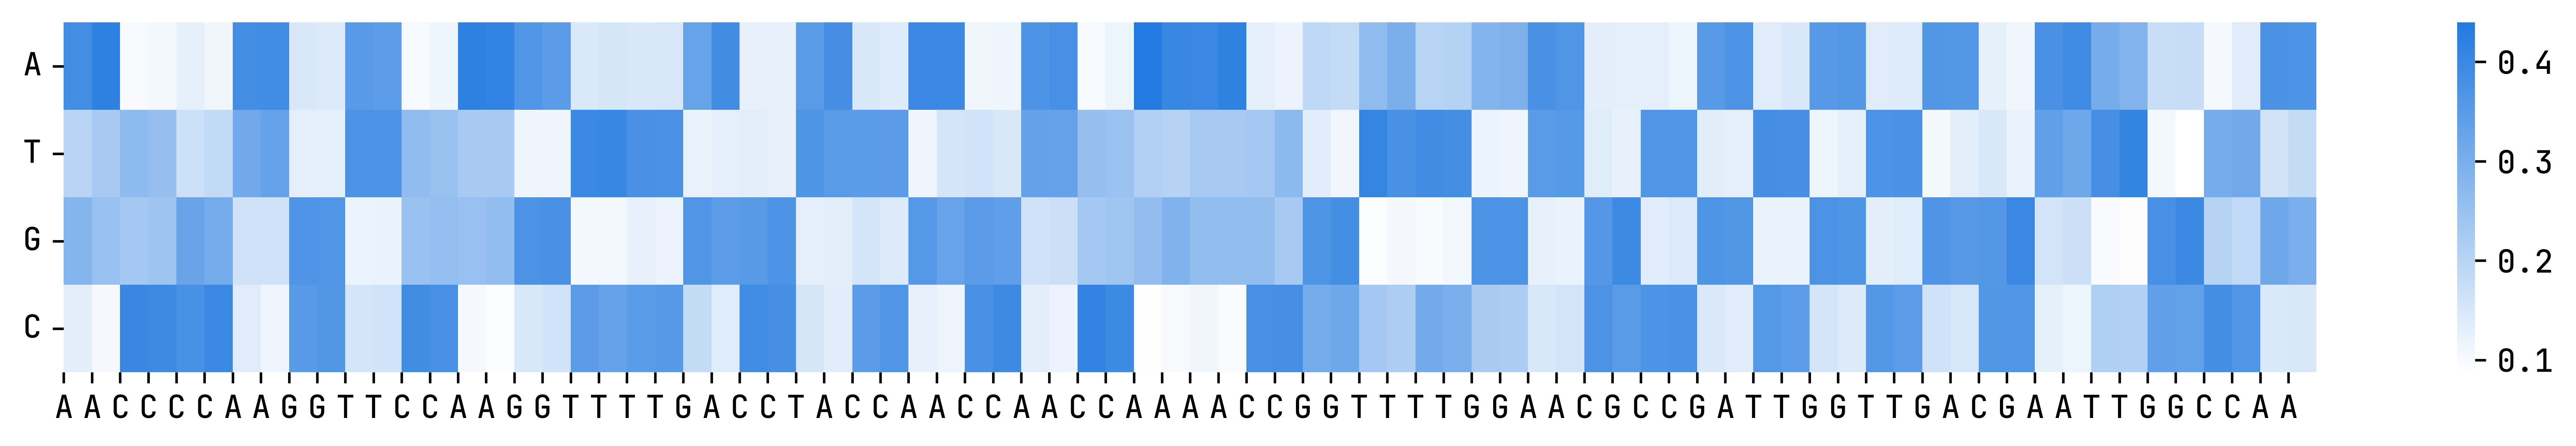

In [25]:
fig, ax = plt.subplots(figsize=(16, 2), dpi=600)
sns.heatmap(preds[0].detach().cpu().numpy(), ax=ax, cmap=custom_cmap)

custom_xticks = list(range(0, 80))
custom_xtick_labels = list(ohse.decode(preds.argmax(dim=1))[0])

ax.set_xticks(custom_xticks)
ax.set_xticklabels(custom_xtick_labels)

ax.set_yticklabels(['A', 'T', 'G', 'C'], rotation=0)
plt.show()